In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [6]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [7]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(32, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.build(input_shape=(None, 140))
autoencoder.summary()

Model: "anomaly_detector_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 8)                 5176      
                                                                 
 sequential_3 (Sequential)   (None, 140)               5308      
                                                                 
Total params: 10484 (40.95 KB)
Trainable params: 10484 (40.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
batch_size = 512
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=batch_size,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 3s 100ms/step - loss: 0.0568 - val_loss: 0.0523
Epoch 2/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0528 - val_loss: 0.0503
Epoch 3/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0481 - val_loss: 0.0483
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0435 - val_loss: 0.0455
Epoch 5/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0390 - val_loss: 0.0434
Epoch 6/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0350 - val_loss: 0.0412
Epoch 7/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0314 - val_loss: 0.0393
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0288 - val_loss: 0.0382
Epoch 9/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0274 - val_loss: 0.0375
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0264 - val_loss: 0.0369
Epoch 11/20
5/5 [===========

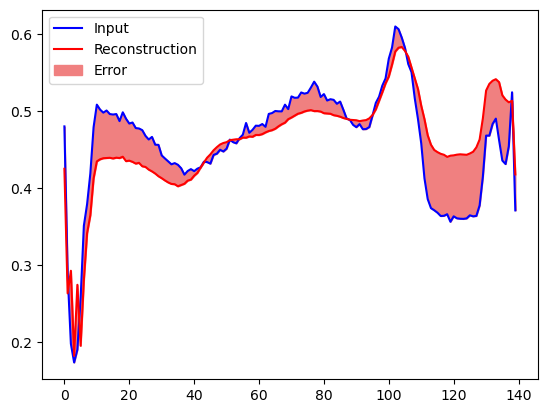

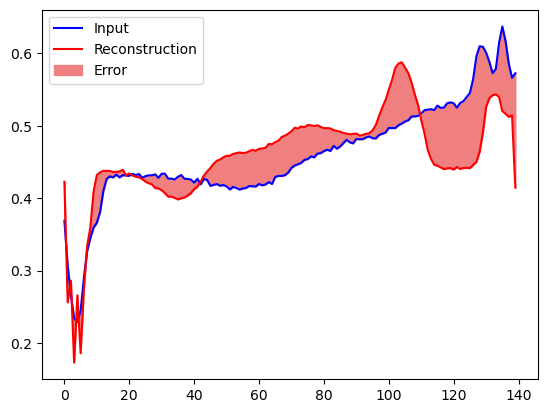

74/74 [==============================] - 0s 2ms/step


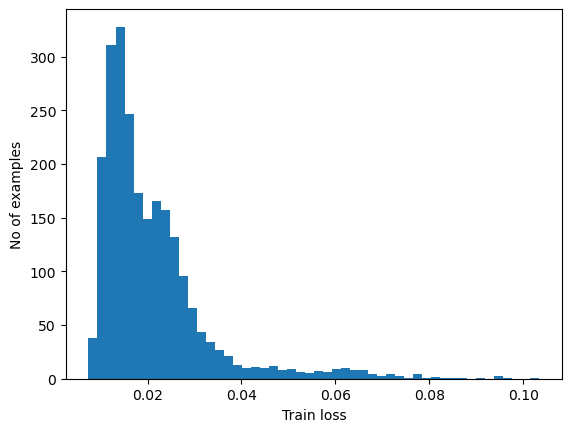

Threshold:  0.033263408
14/14 [==============================] - 0s 2ms/step


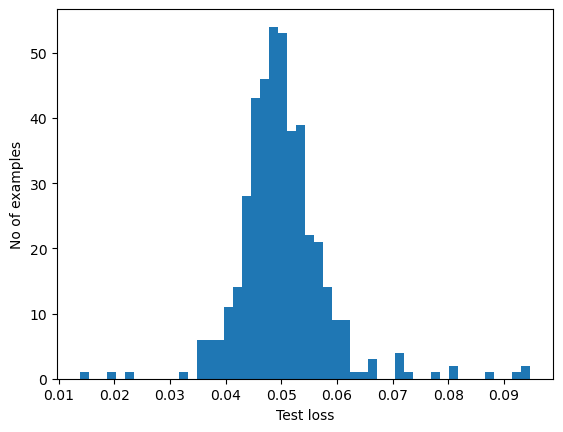

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571


In [9]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

    
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

In [10]:
# Some parameters
input_shape = (140, )  # Input shape, change this as per your needs
encoding_dim = 8  # Number of neurons in the encoding layer

# Define the Encoder
class Encoder(layers.Layer):
    def __init__(self, encoding_dim):
        super(Encoder, self).__init__()
        self.dense = layers.Dense(encoding_dim, activation='relu')
        self.attention = layers.Attention()
        self.norm = layers.LayerNormalization()

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.norm(x)
        
        # In order to use Attention layer we need to expand dimensions
        # because Attention layer expects a 3D tensor.
        x = tf.expand_dims(x, axis=1)
        x = x + self.attention([x, x])

        return tf.squeeze(x, axis=1)

In [11]:
# Define the Decoder
class Decoder(layers.Layer):
    def __init__(self, original_dim,):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(original_dim, activation='sigmoid')
        self.norm = layers.LayerNormalization()
        self.attention = layers.Attention()
        
    def call(self, inputs):
        x = self.norm(inputs)
        x = tf.expand_dims(x, axis=1)

        attn_output = x + self.attention([x, x])
        attn_output = tf.squeeze(attn_output, axis=1)
        
        decoded = self.dense(attn_output)
        
        return decoded

In [12]:
# Define the Autoencoder
class Autoencoder(tf.keras.Model):
    def __init__(self, original_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(encoding_dim)
        self.decoder = Decoder(original_dim)

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Build the autoencoder
autoencoder = Autoencoder(input_shape[0], encoding_dim)
autoencoder.build(input_shape=(None, input_shape[0]))

# Define the optimizer and the loss function
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1144      
                                                                 
 decoder (Decoder)           multiple                  1276      
                                                                 
Total params: 2420 (9.45 KB)
Trainable params: 2420 (9.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
batch_size = 512
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=batch_size,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 83ms/step - loss: 0.1298 - val_loss: 0.1182
Epoch 2/20
5/5 [==============================] - 0s 13ms/step - loss: 0.1105 - val_loss: 0.1068
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0979 - val_loss: 0.0936
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0838 - val_loss: 0.0824
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0726 - val_loss: 0.0735
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0630 - val_loss: 0.0656
Epoch 7/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0550 - val_loss: 0.0595
Epoch 8/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0483 - val_loss: 0.0544
Epoch 9/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0427 - val_loss: 0.0495
Epoch 10/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0377 - val_loss: 0.0456
Epoch 11/20
5/5 [============

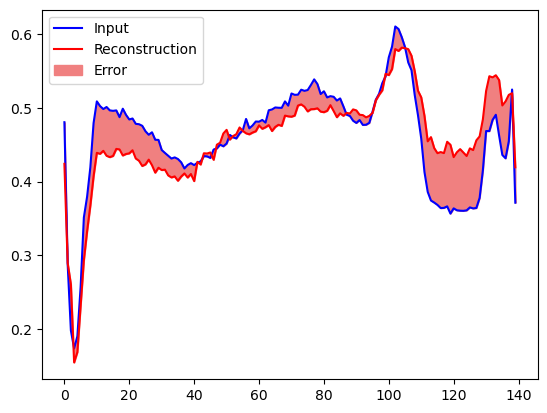

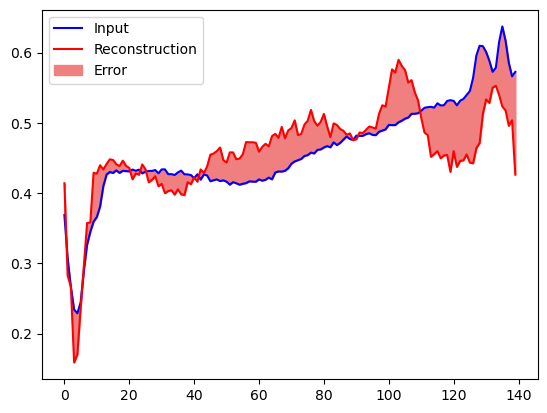

74/74 [==============================] - 0s 2ms/step


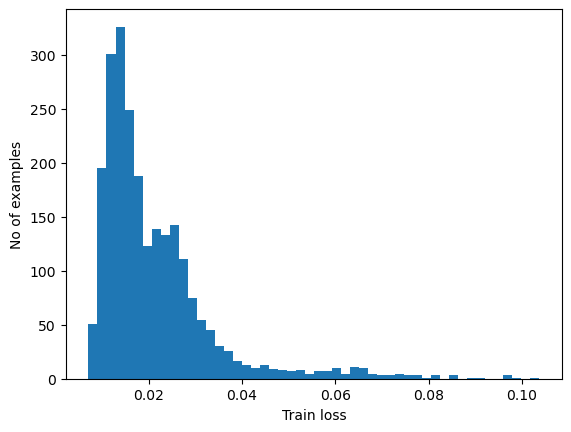

Threshold:  0.033823226
14/14 [==============================] - 0s 2ms/step


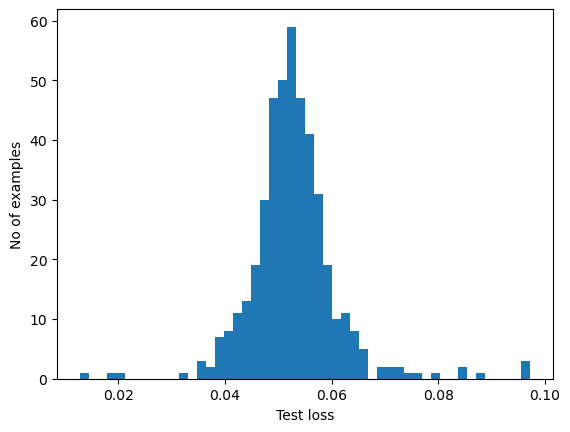

Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714


In [15]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

    
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)